# Inpainting

_Issam Benamara_ & _Ismaël Bonneau_

_mini projet de Master 1 DAC_


L’**inpainting** en image s’attache à la reconstruction d’images détériorées ou au remplissage de parties
manquantes (éliminer une personne ou un objet d’une image par exemple). Cette partie est consacrée
à l’implémentation d’une technique d’inpainting présentée dans <a href="https://www.researchgate.net/publication/220736614_Image_inpainting_via_sparse_representation">[1]</a> utilisant la régression linéaire Lasso (ou L1 régularization) et sa capacité à
trouver une solution sparse en termes de poids. Ces travaux sont inspirés des recherches en
apprentissage de dictionnaire et représentation sparse pour les signaux <a href="https://www.di.ens.fr/willow/events/cvml2010/materials/INRIA_summer_school_2010_Julien.pdf">[2]</a>.

L’idée principale
est de considérer qu’un signal complexe peut être décomposé comme une somme pondérée de signaux
élémentaires. 


### Préambule : régression linéaire, régression ridge et LASSO

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from math import *
import matplotlib.colors as col
import random

%matplotlib inline

In [44]:
def load_usps(fn):
    with open(fn,"r") as f:
        f.readline()
        data = [[float(x) for x in l.split()] for l in f if len(l.split())>2]
    tmp=np.array(data)
    return tmp[:,1:],tmp[:,0].astype(int)

In [7]:
def show_usps(data):
    plt.axis('off')
    plt.imshow(data.reshape((16,16)),interpolation="nearest",cmap="gray")

def plot_error(datax,datay,f,step=10):
    grid,x1list,x2list=make_grid(xmin=-4,xmax=4,ymin=-4,ymax=4)
    plt.contourf(x1list,x2list,np.array([f(datax,datay,w) for w in grid]).reshape(x1list.shape),25)
    plt.colorbar()
    plt.show()

In [4]:
dtrx , dtry = load_usps("USPS_train.txt")
dtex , dtey = load_usps("USPS_test.txt")

## Comparaison: 

### régression linéaire vs régression ridge (L2 régularization) vs algorithme du Lasso

Nous allons comparer les 3 méthodes et montrer leur impact sur le vecteur de poids obtenu au final. Pour cela on utilise les données USPS qui sont des images de taille 16x16 de chiffres manuscrits.

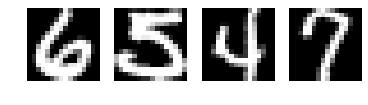

In [16]:
for i in range(4):
    plt.subplot(1,4,i+1)
    show_usps(dtrx[i])

### Régression linéaire

In [10]:
#création de notre régression linéaire
reg_lin = linear_model.LinearRegression()
#apprentissage
reg_lin.fit(dtrx, dtry)
#prédiction
pred_train = reg_lin.predict(dtrx)
pred_test = reg_lin.predict(dtex)
#affichage des résultats
#print("Les coefficients sont : ", reg_lin.coef_)
mse_train = mean_squared_error(dtry, pred_train)
mse_test = mean_squared_error(dtey, pred_test)
print("Cout quadratique moyenne (MSE) du train : ", mse_train)
print("Cout quadratique moyenne (MSE) du test : ", mse_test)
print("Score variance train : ", r2_score(dtry, pred_train))
print("Score variance test : ", r2_score(dtey, pred_test))
print("Norme du vecteur de poids : ",np.linalg.norm(reg_lin.coef_))
print("Nombre de composantes non nulles : ",np.count_nonzero(reg_lin.coef_))

Cout quadratique moyenne (MSE) du train :  3.093907292463029
Cout quadratique moyenne (MSE) du test :  3.7549053135627144
Score variance train :  0.6553555286479579
Score variance test :  0.587676847955118
Norme du vecteur de poids :  4.055685527236994
Nombre de composantes non nulles :  256


#### Résultat: 

sur 256, composantes du vecteur de poids ${W}$, toutes sont non nulles.

### Ridge regression (régression linéaire + L2 regularization)

avec la ridge régression le problème devient: ${\min_{W} \sum_{i=1}^{n} (y_i - \sum_{j=1}^{p} W_j X_{i,j}) + \alpha \sum_{j=1}^{p} W_j^2}$

Le paramètre ${\alpha}$ contrôle la régularization: plus ${\alpha}$ est grand, plus la régularization est importante et le modèle va chercher à obtenir les poids les plus petits possible.

In [17]:
alpha = [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 0.5, 1, 5, 10, 30, 100]

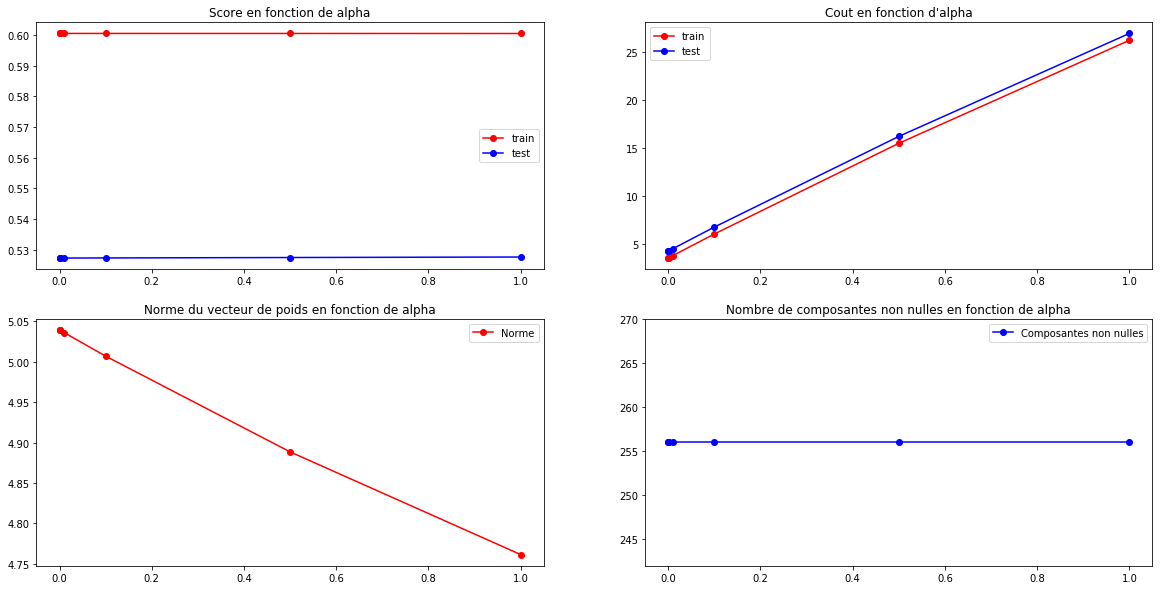

In [57]:
score_train = []
score_test = []
cout_train = []
cout_test = []
normes = []
compo_non_nulles = []

for a in alpha:
    ridge = linear_model.Ridge(alpha=a, fit_intercept=False)
    ridge.fit(dtrx, dtry)
    score_train.append(ridge.score(dtrx, dtry))
    score_test.append(ridge.score(dtex, dtey))
    
    pred_train = ridge.predict(dtrx) 
    pred_test = ridge.predict(dtex)
    w = sqrt(sum(np.array(ridge.coef_)*np.array(ridge.coef_)))
    cout_train.append(mean_squared_error(dtry, pred_train) + a*(w**2))
    cout_test.append(mean_squared_error(dtey, pred_test) + a*(w**2))
    
    normes.append(np.linalg.norm(ridge.coef_))
    compo_non_nulles.append(np.count_nonzero(ridge.coef_))
    
plt.figure(figsize=(20,10))

plt.subplot(2,2,1)
plt.plot(alpha, score_train, marker="o", color='red', label='train')
plt.plot(alpha, score_test, marker="o", color='blue', label='test')
plt.title("Score en fonction de alpha")
plt.legend()
plt.subplot(2,2,2)
plt.plot(alpha, cout_train, marker="o", color='red', label="train")
plt.plot(alpha, cout_test, marker="o", color='blue', label="test")
plt.title("Cout en fonction d'alpha")
plt.legend()
plt.subplot(2,2,3)
plt.plot(alpha, normes, marker="o", color='red', label='Norme')
plt.title("Norme du vecteur de poids en fonction de alpha")
plt.legend()
plt.subplot(2,2,4)
plt.plot(alpha, compo_non_nulles, marker="o", color='blue', label='Composantes non nulles')
plt.title("Nombre de composantes non nulles en fonction de alpha")
plt.legend()
plt.show()

### Résultat: 

sur 256, composantes du vecteur de poids ${W}$, la plupart sont non nulles. La régression Ridge n'a pas pour effet de mettre des composantes à 0, mais plutôt de les rendre très petites (quand c'est possible). On voit que la norme de ${W}$ réduit considérablement avec l'augmentation de ${\alpha}$. On peut visualiser la répartition des valeurs de poids sur l'image:

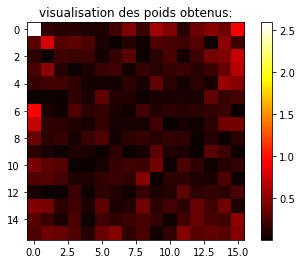

In [65]:
plt.title('visualisation des poids obtenus:')
plt.imshow(np.abs(ridge.coef_.reshape((16,16))),interpolation="nearest",cmap="hot")
plt.colorbar()
plt.show()

### Ridge regression (régression linéaire + L2 regularization)

avec la ridge régression le problème devient: ${\min_{W} \sum_{i=1}^{n} (y_i - \sum_{j=1}^{p} W_j X_{i,j}) + \alpha \sum_{j=1}^{p} |W_j|}$

Le paramètre ${\alpha}$ contrôle la régularization: plus ${\alpha}$ est grand, plus la régularization est importante et le modèle va chercher à obtenir les poids les plus petits possible.

In [32]:
alpha = [0.00001, 0.0001, 0.001, 0.01, 0.1, 0.5, 1]

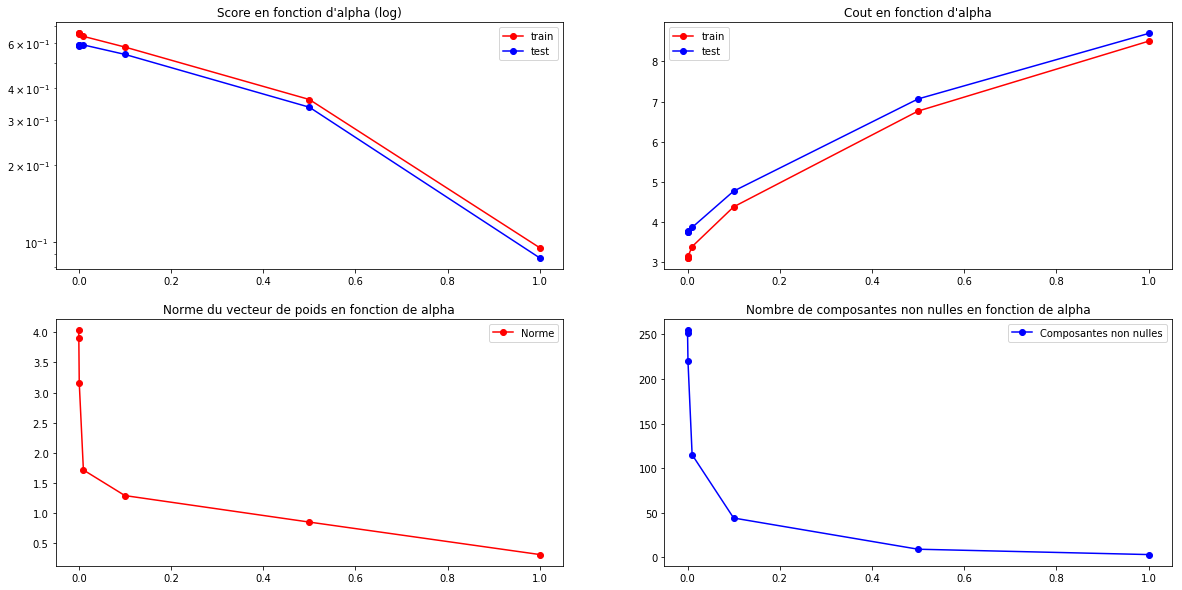

In [71]:
score_test = []
score_train = []
cout_train = []
cout_test = []

normes = []
compo_non_nulles = []

for a in alpha:
    reg_las = linear_model.Lasso(alpha=a, max_iter = 2000)
    reg_las.fit(dtrx, dtry)
    score_test.append(reg_las.score(dtex,dtey))
    score_train.append(reg_las.score(dtrx, dtry))
    
    pred_train = reg_las.predict(dtrx) 
    pred_test = reg_las.predict(dtex)
    w = sum([abs(x) for x in reg_las.coef_])
    cout_train.append(mean_squared_error(dtry, pred_train) + a*w)
    cout_test.append(mean_squared_error(dtey, pred_test) + a*w)
    
    normes.append(np.linalg.norm(reg_las.coef_))
    compo_non_nulles.append(np.count_nonzero(reg_las.coef_))

plt.figure(figsize=(20,10))
plt.subplot(2,2,1)
plt.yscale("log")
plt.plot(alpha, score_train, marker="o", color='red', label='train')
plt.plot(alpha, score_test, marker="o", color='blue', label='test')
plt.title("Score en fonction d'alpha (log)")
plt.legend()
plt.subplot(2,2,2)
plt.plot(alpha, cout_train, marker="o", color='red', label="train")
plt.plot(alpha, cout_test, marker="o", color='blue', label="test")
plt.title("Cout en fonction d'alpha")
plt.legend()
plt.subplot(2,2,3)
plt.plot(alpha, normes, marker="o", color='red', label='Norme')
plt.title("Norme du vecteur de poids en fonction de alpha")
plt.legend()
plt.subplot(2,2,4)
plt.plot(alpha, compo_non_nulles, marker="o", color='blue', label='Composantes non nulles')
plt.title("Nombre de composantes non nulles en fonction de alpha")
plt.legend()
plt.show()

### Résultat: 

sur 256, composantes du vecteur de poids ${W}$, la plupart sont nulles. La régression Ridge a pour effet de mettre des composantes à 0, grâce à l'utilisation de la valeur absolue. On voit que la norme de ${W}$ réduit considérablement avec l'augmentation de ${\alpha}$. On peut visualiser la répartition des valeurs de poids sur l'image:

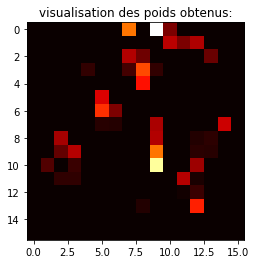

In [70]:
plt.title('visualisation des poids obtenus:')
plt.imshow(np.abs(reg_las.coef_.reshape((16,16))),cmap="hot")
plt.show()

### Regardons quel est le meilleur modèle sur ces données

cross validation + gridsearch pour lasso et ridge

In [93]:
from sklearn.model_selection import GridSearchCV

parameters = {'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1, 0.5, 1]}

reg_las = linear_model.Lasso(max_iter=2000)

gridsearch = GridSearchCV(reg_las, parameters, cv=5, return_train_score=True)
_ = gridsearch.fit(dtrx, dtry)

print("meilleur score: {0:.2f}".format(gridsearch.best_score_*100), "pour alpha", gridsearch.best_params_['alpha'])

meilleur score: 61.98 pour alpha 0.001


In [94]:
parameters = {'alpha': [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 0.5, 1, 5, 10, 30, 100]}

reg_ridge = linear_model.Ridge(max_iter=2000)

gridsearch = GridSearchCV(reg_ridge, parameters, cv=5, return_train_score=True)
_ = gridsearch.fit(dtrx, dtry)

print("meilleur score: {0:.2f}".format(gridsearch.best_score_*100), "pour alpha", gridsearch.best_params_['alpha'])

meilleur score: 62.19 pour alpha 100


In [95]:
from sklearn.model_selection import cross_validate

reg = linear_model.LinearRegression()
cv = cross_validate(reg, dtrx, dtry, cv=5)

print("meilleur score: {0:.2f}".format(cv['test_score'].mean()*100))

meilleur score: 61.58


### Résultat:

La ridge regression semble mieux performer sur ce jeu de données. Ridge et Lasso sont meilleures que régression simple.

## inpainting

### Reconstitution à l'aide du LASSO

### Formalisation

Pour une image en 2 dimensions, nous noterons ${p_{i,j} \in [0, 1]^3}$
le pixel aux coordonnées ${(i, j)}$ de l’image
exprimée sur 3 canaux : ces 3 canaux sont usuellement le pourcentage de rouge, de vert et de bleu
(RGB) de la couleur, ou sous format teinte, saturation, luminosité (HVS, Hue Saturation Value), plus proche de notre perception visuelle.

Nous appellerons dans la suite un patch un petit carré de l’image de longueur de côté h
(cette longueur sera une constante fixée au préalable). Nous noterons ${\psi^{p_{i,j}}}$ le patch dont le centre
est le pixel ${p_{i,j}}$ . Ce patch correspond à une matrice 3d (un tenseur) de taille ${h \times h \times 3}$ que l’on
peut voir sans perte de généralité comme un vecteur colonne de taille ${3h^2}$ à partir d’une image de
taille ${(width, height)}$, il est possible de construire l’ensemble des patchs ${\psi}$ constituant cette image :
${\psi = {\psi^{p_{i,j}} \in [0, 1]^{3h^2}, i \in \left \{{\frac{h}{2} ... width - \frac{h}{2}} \right \}, j \in \left \{{\frac{h}{2}... height - \frac{h}{2}}\right \}}}$.

De manière générale en inpainting, une hypothèse fondamentale est qu’une image a une cohérence
spatiale et de texture : un patch ${\psi^p}$ appartenant à une région cohérente en termes de texture doit
pouvoir être reconstruit à partir d’une pondération des patchs environnants : ${\psi^p = \sum_{\psi^{p_k} \in \psi\ \psi^{p}} w_k \psi^{p}_k}$.


Bien sûr, c'est le grand **Kratos**, fils de Zeus, qui vas nous servir d'exemple d'image à reconstituer. Qui d'autre que lui?

<img src="images/kratos.jpg" >

In [2]:
#constante pour signifier une valeur manquante
MISSING = -100


def read_im(fn) :
    return plt.imread(fn).copy().astype("int32")/255
  
def show_im(arr, figsize = None, title = None):
    arr3 = arr.copy()
    arr3[arr3 == MISSING] = 0
    if figsize != None:
        plt.figure(figsize=figsize)
    else:
        plt.figure()
    if title != None:
        plt.title(title)
    plt.axis("off")
    plt.imshow(arr3)
    plt.show()
    
def vecteur(patch):
    """
    transforme un patch en vecteur
    """
    return patch.ravel().copy()
  
def patch(vecteur, h):
    """
    ne marche qu'avec des patchs carrés
    """
    return vecteur.reshape((h , h , 3 ))
  

def noise( im_arr , prc  ):
    arr_hole = im_arr.copy()
    nbPixels = arr_hole.shape[0]*arr_hole.shape[1]
    toBlack = random.sample(range(nbPixels),int(nbPixels*prc))
    for pixel in toBlack:
        i = pixel // arr_hole.shape[1]
        j = pixel % arr_hole.shape[1]
        arr_hole[ i, j ] = np.ones(3)*(MISSING)
    return arr_hole
  
def del_rect(img, i, j, height, width):
    res = img.copy()
    for ix in range(i, i+height):
        for jx in range(j, j+width):
            res[ix][jx] = np.ones(3)*(MISSING)
    return res
  
def white_to_missing(img):
    res = img.copy()
    for ix in range(img.shape[0]):
        for jx in range(img.shape[1]):
            if np.prod( res[ix][jx] == np.ones(3)) == 1:
                res[ix][jx] = np.ones(3)*(MISSING)
    return res
  
def get_patch(  i , j , h , im_arr ):
    start_i , start_j = i-h//2 , j-h//2
    return im_arr[ start_i : start_i+h , start_j : start_j+h , : ].copy()
  
def fill_patch(  i , j , h , im_arr, filler_patch ):
    if len(filler_patch) != h:
        return
    start_i , start_j = i-h//2 , j-h//2
    im_arr[ start_i : start_i+h , start_j : start_j+h , : ] = filler_patch

def get_all_patches( array_img, h, step ):
    bad_patches = dict()
    good_patches = dict()
    width = array_img.shape[1]
    height = array_img.shape[0]

    i = h//2  
    while i < height :
        j = h//2
        while j < width:
            tmp_patch = get_patch( i, j, h, array_img )
            if tmp_patch.shape != (h,h,3):
                j += step
                continue
            if MISSING in tmp_patch:
                bad_patches[(i,j)] = tmp_patch
            else:
                good_patches[(i,j)] = tmp_patch
            j += step
        i += step

    return bad_patches, good_patches
  
def reconstruct(patches_dict, target_img, h, step ):
    width = target_img.shape[1]
    height = target_img.shape[0]

    a = np.array(list(patches_dict.items()))
    a = a[a[:,0].argsort()]

    lines = []

    c = 0
    for i in range(height//h):
        line = []
        for j in range(width//h):
            line.append(a[c][1])
            c += 1
        lines.append(tuple(line))

    rows = []
    for line in lines:
        rows.append(np.concatenate(line, axis=1))

    rows = tuple(rows)

    return np.concatenate(rows, axis=0)
  
def magic( raw, target, h, step, a = 0.00001, iterations = 1000, plot=True):
    """
    Fonction magique qui reconstruit une image
    """
    bad_patches, good_patches_recon = get_all_patches(raw, h = h, step = h)
    _, good_patches = get_all_patches(raw, h = h, step = step)
  
    X = np.zeros((len(good_patches),np.prod(list(good_patches.values())[0].shape)))
    for i, p in enumerate(good_patches.keys()):
        patch_ = good_patches[p]
        X[i] = vecteur(patch_)
    X = X.T
  
    for k in bad_patches.keys():
        target_patch = bad_patches[k]

        Y = vecteur(target_patch)
        Y = Y.reshape((len(Y),1))

        filter_ = np.where(Y != -100)[0]

        Y_filtered = Y[filter_]
        X_filtered = X[filter_]

        l_app = X_filtered

        l_patch = Y_filtered

        reg_las = linear_model.Lasso(alpha=a, max_iter=iterations)

        reg_las.fit(l_app, l_patch)

        pred = reg_las.predict(X)
        final = Y.ravel()
        pred[filter_] = final[filter_]
        bad_patches[k] = patch(pred,h)
    
    d_final = dict(good_patches_recon)
    d_final.update(bad_patches)

    reconstructed = reconstruct(d_final, raw, h, h )
    if plot:
        #Affichage de la version originale, bruitée, reconstituée
        plt.figure(figsize=(15,10))
        plt.subplot(1,3,1)
        plt.axis('off')
        plt.title('original image')
        plt.imshow(target)

        plt.subplot(1,3,2)
        plt.axis('off')
        plt.title('altered image')
        plt.imshow(raw)

        plt.subplot(1,3,3)
        plt.axis('off')
        plt.title('reconstructed image')
        plt.imshow(reconstructed)

        plt.show()
  
    return reconstructed

def magic_local( raw, target, tp_i, tp_j, tp_h, step, a = 0.00001, iterations = 1000, plot=True):
  
    _, good_patches = get_all_patches(raw, h = tp_h, step = step)
  
    X = np.zeros((len(good_patches),np.prod(list(good_patches.values())[0].shape)))
    for i, p in enumerate(good_patches.keys()):
        patch_ = good_patches[p]
        X[i] = vecteur(patch_)
    X = X.T
  
    bad_patch = get_patch(tp_i, tp_j, tp_h, raw)
  
    target_patch = bad_patch

    Y = vecteur(target_patch)
    Y = Y.reshape((len(Y),1))

    filter_ = np.where(Y != -100)[0]

    Y_filtered = Y[filter_]
    X_filtered = X[filter_]

    l_app = X_filtered

    l_patch = Y_filtered

    reg_las = linear_model.Lasso(alpha=a, max_iter=iterations)

    reg_las.fit(l_app, l_patch)

    pred = reg_las.predict(X)
    final = Y.ravel()
    pred[filter_] = final[filter_]
    bad_patch = patch(pred,tp_h)
    
    reconstructed = raw.copy()
  
    fill_patch(tp_i,tp_j,tp_h,reconstructed,bad_patch)
    if plot:
        #Affichage de la version originale, bruitée, reconstituée
        plt.figure(figsize=(15,10))
        plt.subplot(1,3,1)
        plt.axis('off')
        plt.title('original image')
        plt.imshow(target)

        plt.subplot(1,3,2)
        plt.axis('off')
        plt.title('altered image')
        plt.imshow(raw)

        plt.subplot(1,3,3)
        plt.axis('off')
        plt.title('reconstructed image')
        plt.imshow(reconstructed)

        plt.show()
  
    return reconstructed

## Regardons ce que donne une photo de Kratos, avec 20% de pixels manquants:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


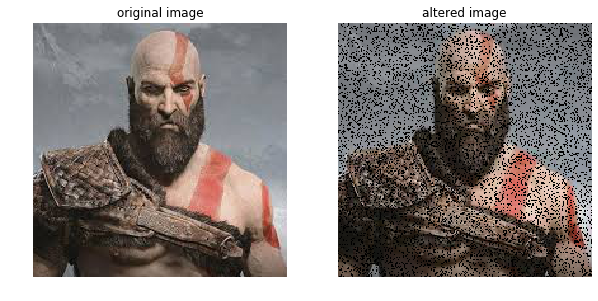

In [3]:
array_img =  read_im("images/kratos.jpg")
array_img = array_img [:200][:,20:220]
noisy_img = noise(array_img,0.2)

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.axis('off')
plt.title('original image')
plt.imshow(array_img)
plt.subplot(1,2,2)
plt.axis('off')
plt.title('altered image')
plt.imshow(noisy_img)
plt.show()

**Quel charisme!**

Construisons tous les patches de taille ${h = 40}$ avec un pas ${step = 5}$ à partir de l'image entière, pour les utiliser en tant que dictionnaire.

In [17]:
bad_patches, good_patches = get_all_patches(array_img, h = 40, step = 5)
len(bad_patches), len(good_patches)

(0, 1089)

Essayons de reconstruire ce patch du visage du dieu de la guerre déchu en utilisant le dictionnaire (tous les patches de l'image, sauf le patch "cible" à reconstituer que l'on va supprimer du dictionnaire).

#### Voici le patch:

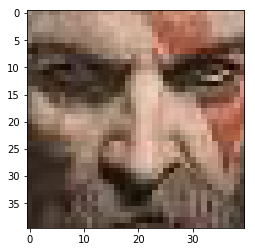

In [18]:
target_patch = get_patch( i = 60 , j = 105 , h = 40, im_arr = array_img )
show_im(target_patch)

Supprimons le patch à reconstruire du dictionnaire pour eviter d'avoir un vecteur poids nul partout avec un seul '1' qui va pondérer le patch objectif lui même au maximum

In [19]:
del good_patches[(60,105)]

Convertissons tous les patches du dictionnaire en une matrice pour l'utiliser dans la régression LASSO.

Dans notre cas on obtient une matrice ${4800 \times 1088}$ ce qui s'explique par :
- Un patch de ${h = 40}$ est converti en un vecteur colonne ${40\times40\times3 = 4800}$
- Nous avons 1088 patches dans le dictionnaire

Donc chaque colonne correspond à un patch et chaque ligne correspond à une couche d'un pixel donné.

In [20]:
X = np.zeros((len(good_patches),np.prod(target_patch.shape)))
for i, p in enumerate(good_patches.keys()):
    patch_ = good_patches[p]
    X[i] = vecteur(patch_)
X = X.T
X.shape

(4800, 1088)

De même pour le patch objectif ( un seul vecteur colonne donc ${4800 \times 1}$)

In [21]:
Y = vecteur(target_patch)
Y = Y.reshape((len(Y),1))
Y.shape

(4800, 1)

/home/ismael/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


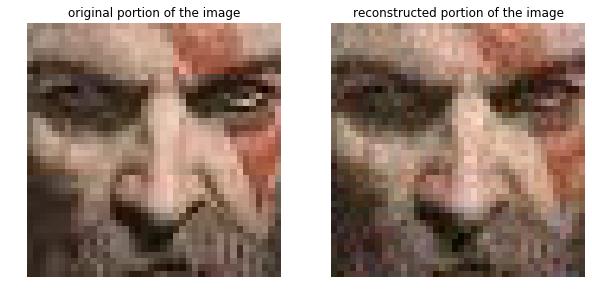

In [23]:
a = 0.0000001 #coefficient de régularization L1 (appelé souvent alpha)

l_app = X #matrice de pixels, patches
l_patch = Y #patch objectif

#modèle Lasso
reg_las = linear_model.Lasso(alpha=a, max_iter=1000)
reg_las.fit(X, Y)

#on récupère les poids
w = reg_las.coef_

#on prédit l'image entière
pred = reg_las.predict(l_app)

sum_w = sum([abs(x) for x in w])

cout = mean_squared_error(l_patch, pred) + a*sum_w

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.axis('off')
plt.title('original portion of the image')
plt.imshow(target_patch)
plt.subplot(1,2,2)
plt.axis('off')
plt.title('reconstructed portion of the image')
plt.imshow(patch(pred,40))
plt.show()

Le **résultat** parait bon!

Maintenant essayons de compléter l'image avec des pixels manquants en utilisant toujours l'image correcte complète comme dictionnaire.

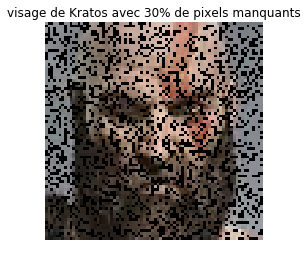

In [101]:
target_patch = noise(get_patch( i = 60 , j = 105 , h = 80, im_arr = array_img ), 0.3 )
show_im(target_patch, title="visage de Kratos avec 30% de pixels manquants")

In [102]:
bad_patches, good_patches = get_all_patches(array_img, h = 80, step = 5)
del good_patches[(60,105)]
len(bad_patches), len(good_patches)

(0, 624)

In [103]:
X = np.zeros((len(good_patches),np.prod(target_patch.shape)))
for i, p in enumerate(good_patches.keys()):
    patch_ = good_patches[p]
    X[i] = vecteur(patch_)
X = X.T
X.shape

(19200, 624)

In [104]:
Y = vecteur(target_patch)
Y = Y.reshape((len(Y),1))
Y.shape

(19200, 1)

On filtre les patches selon les pixels présents dans le patch objectif, pour n'appliquer la régression que sur les pixels présents

In [105]:
filter_ = np.where(Y != -100)[0]

Y_filtered = Y[filter_]
X_filtered = X[filter_]

Y_filtered.shape, X_filtered.shape

((13440, 1), (13440, 624))

In [106]:
a = 0.00001
l_app = X_filtered

l_patch = Y_filtered

reg_las = linear_model.Lasso(alpha=a)

reg_las.fit(l_app, l_patch)

w = reg_las.coef_

pred = reg_las.predict(l_app)

sum_w = sum([abs(x) for x in w])

cout = mean_squared_error(l_patch, pred) + a*sum_w

/home/ismael/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


On remplace les pixels manquants dans l'objectif par les pixels prédits

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


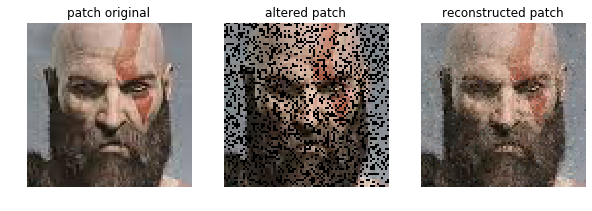

In [115]:
pred = reg_las.predict(X)
final = Y.ravel()

plt.figure(figsize=(10,10))
plt.subplot(1,3,1)
plt.axis("off")
plt.title("patch original")
plt.imshow(get_patch(60, 105, 80, array_img))
plt.subplot(1,3,2)
plt.axis("off")
plt.title("altered patch")
plt.imshow(target_patch)
pred[filter_] = final[filter_]
plt.subplot(1,3,3)
plt.axis("off")
plt.title("reconstructed patch")
plt.imshow(patch(pred,80))
plt.show()

**Généralisation**

A présent, au lieu de considérer comme dictionnaire l'image correcte au complet (ce qui est impossible en réalité sinon on ne chercherait pas à corriger le bruit ou les pixels manquants) on va considérer les patches "propres" de l'image en tant que dictionnaire.

Nous allons donc utiliser le même processus qu'avant mais tout est inclus dans une fonction pour ne faire qu'un seul appel.

Testons avec cette image (remarquez le taux de bruitage plutôt élevé et l'utilisation d'une taille de patch petite pour tenter d'obtenir le maximum de patches propres)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


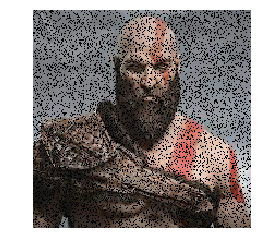

In [4]:
noisy_img = noise(array_img,0.2)
plt.axis('off')
plt.imshow(noisy_img)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


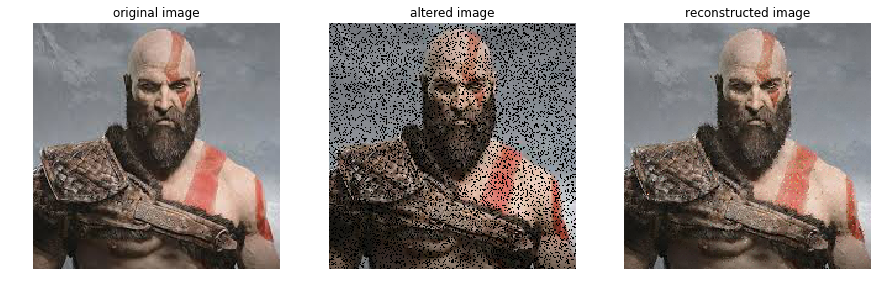

In [5]:
_ = magic(noisy_img, array_img, h = 5, step = 5)

Passons à un test plus aggressif en supprimant tout un groupe de pixels adjacents et en essayant de "remplir" le vide.

**Attention** il faut que h soit assez grand pour couvrir strictement les pixels manquants, sinon comme patch objectif nous allons avoir un patch tout vide donc durant la régression nous n'allons avoir aucun pixels correctes comme objectif.

**avec un ${\alpha = 0.00001}$**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


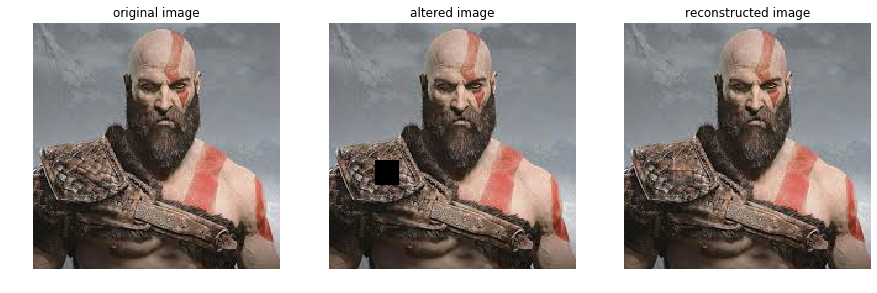

In [16]:
import warnings
warnings.simplefilter("ignore")

missing_rect_img = del_rect(array_img, i = 112, j = 37, height = 20, width = 20)
_ = magic(missing_rect_img, array_img, h = 40, step = 10, iterations = 1000 )

**avec un ${\alpha = 0.001}$**...

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


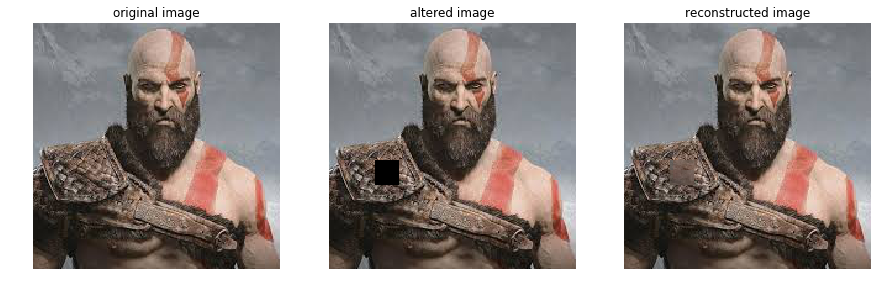

In [19]:
_ = magic(missing_rect_img, array_img, h = 40, step = 10, iterations = 1000, a=0.001)

**Et avec un ${\alpha = 1.}$** (ne fonctionne pas du tout, beaucoup trop peu d'atomes).

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


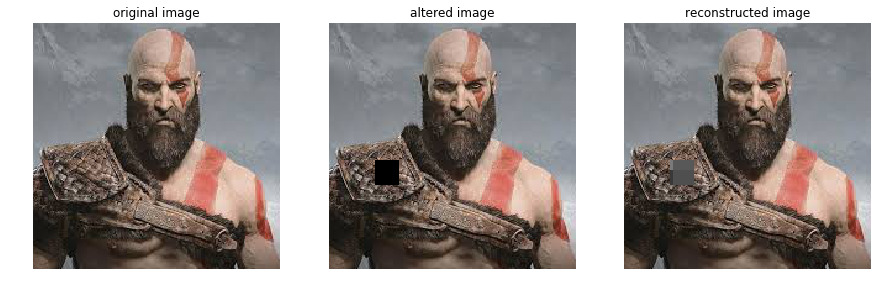

In [20]:
_ = magic(missing_rect_img, array_img, h = 40, step = 10, iterations = 1000, a=1)

#### Et en effet, la MSE entre l'image originale et la reconstruction augmente avec ${\alpha}$

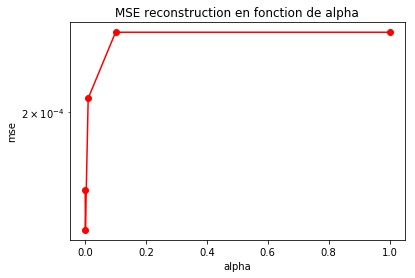

In [26]:
def mse(pred, truth):
    return np.mean(np.square(pred - truth))

mses = []
for alpha in [1, 0.1, 0.01, 0.001, 0.0001]:
    _ = magic(missing_rect_img, array_img, h = 40, step = 10, iterations = 1000, a=alpha, plot=False)
    mses.append(mse(_, array_img))

plt.yscale("log")
plt.plot([1, 0.1, 0.01, 0.001, 0.0001], mses, marker="o", color='red', label='MSE')
plt.title("MSE reconstruction en fonction de alpha")
plt.xlabel("alpha")
plt.ylabel("mse")
plt.show()

**Remarque**

lorsque les modèles ne convergent pas on arrive à voir 4 warnings, indiquant que même avec un h qui couvre totalement, le quadrillage de notre image a fait en sorte qu'on aie 4 patches incorrects (on peut s'imaginer que chaque patch contient un coin du rectangle manquant).

On peut donc envisager une autre manière moins générale, on spécifie exactement quelle partie de l'image on souhaite traiter au lieu de chercher automatiquement tous les patches incorrects et les corriger.

Par exemple essayons juste de corriger ce patch:

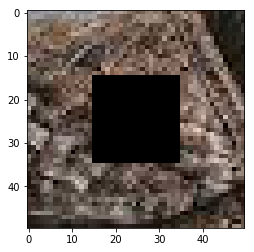

In [135]:
show_im(get_patch(122,47,50,missing_rect_img))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


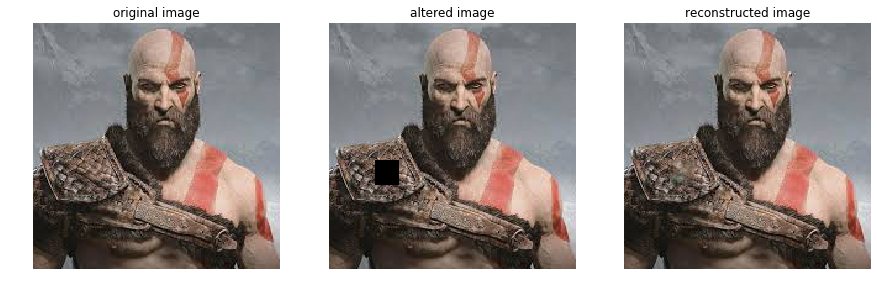

In [128]:
_ = magic_local(missing_rect_img, array_img, tp_i = 122, tp_j = 47, tp_h = 60, step = 5, iterations = 1000 )

C'est déja plus rapide que la méthode générale, mais vu l'emplacement de la zone supprimé il est normal que le résultat ne soit pas parfait vu l'inexistence d'une autre zone très ressemblante dans l'image.

Essayons maintenant avec une image qui contient des motifs de texture:

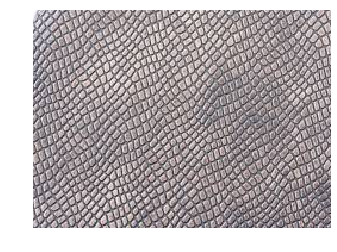

In [129]:
skin =  read_im("images/skin.jpg")
skin = skin [:190][:,:250]
show_im ( skin )

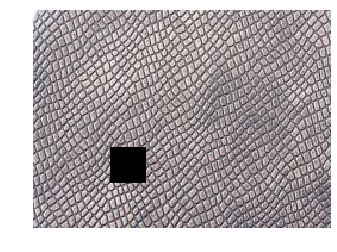

In [130]:
cachee = del_rect(skin, 115,65,30,30)
show_im(cachee)

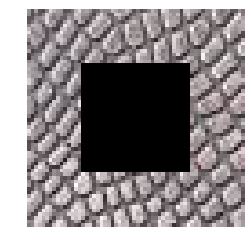

In [131]:
show_im(get_patch(130,80,60,cachee))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


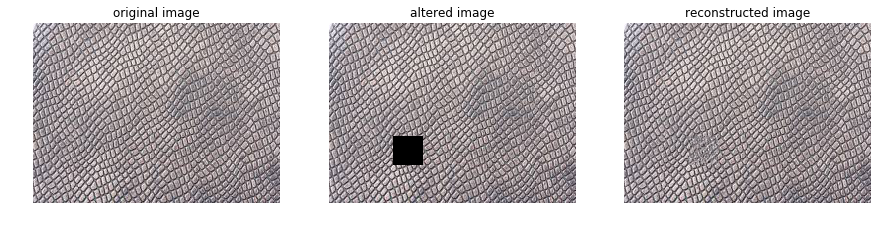

In [132]:
_ = magic_local(cachee, skin, tp_i = 130, tp_j = 80, tp_h = 60, step = 5, a = 0.000001, iterations = 2000 )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


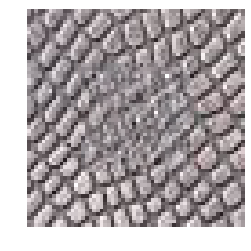

In [133]:
show_im(get_patch(130,80,60,_))

**pas mal! une texture très grossière de peau d'éléphant. Très moche mais pourrait servir pour les prochains jeux Nintendo switch. Nous allons l'envoyer aux développeurs.**

Essayons maintenant la suppression d'un élément de l'image avec remplissage du fond qui prend en compte le contenu.

In [ ]:
arbre =  read_im("images/windowsXP.jpg")
arbre = arbre[:,:600]

In [ ]:
cachee = del_rect(arbre, 70,375,110,97)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


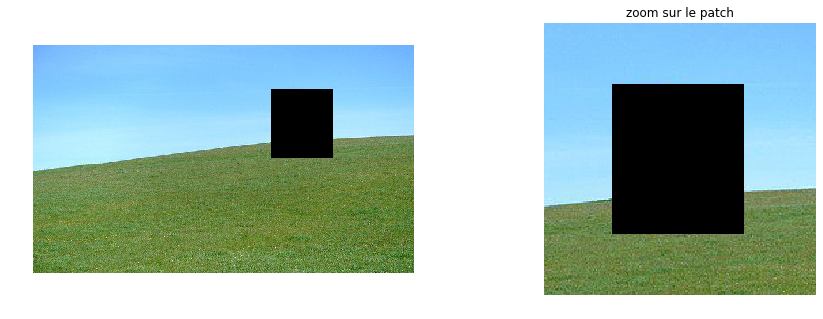

In [161]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.axis("off")
plt.imshow(cachee)
plt.subplot(1,2,2)
plt.title("zoom sur le patch")
plt.imshow(get_patch(125,425,200,cachee))
plt.axis("off")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


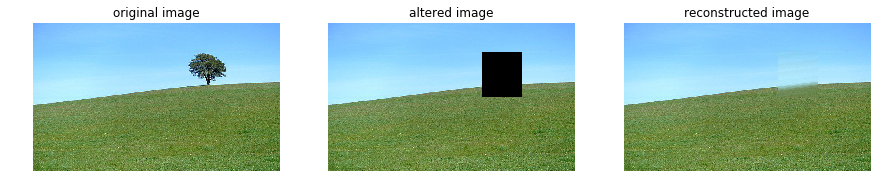

In [142]:
_ = magic_local(cachee, arbre, tp_i = 125, tp_j = 425, tp_h = 200, step = 20, a = 0.00000001, iterations = 1000 )

## Bonus (avec des images en haute résolution)

Pour la science, et aussi pour le plaisir des yeux.

<img src='images/badass_beforeafter.png'>

<img src='images/jormungandr_beforeafter.png'>